In [61]:
!pip -q install --upgrade pip
!pip -q install "hmmlearn>=0.3.2"


#This notebook builds the HMM model and collects the state probabilities for dry, normal or wet state in the next period that are used to enrich the LSTM model

In [62]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Tuple
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_fscore_support, classification_report, confusion_matrix,
    accuracy_score, log_loss
)

In [63]:
#load weather data for SPI

weekly_SPI = pd.read_csv("weekly_spi6_gamma_only.csv", parse_dates=["date"]) #important columns: date & SPI_6
weekly_SPI.head()

,date,weekly_precip,precip_6mo,SPI_6
0,1970-07-05,29.633333,554.183333,NaN
1,1970-07-12,2.766667,555.350000,NaN
2,1970-07-19,23.783333,572.083333,NaN
3,1970-07-26,7.066667,576.266667,NaN
4,1970-08-02,27.283333,596.383333,NaN


We still have NaN values for SPI where the code previously couldnt calculate SPI due to lack of data so we need to get rid of those data points. Now the solution is somewhat roughly implemented, because there are some values of SPI for weeks 52 that show up way before the other week spi, because we cladsified week 53 as 52 so there is more representation. We get rid of these by just starting the time series in 1980. This is a hand made implementation - if we change the sample size in spi calc in weather code file this would need to be changed too.

In [64]:
weekly_SPI = weekly_SPI[weekly_SPI['SPI_6'].notna().cummax()]
weekly_SPI.head()
weekly_SPI["SPI_6_raw"] = weekly_SPI["SPI_6"]
if "date" in weekly_SPI.columns:
    weekly_SPI = weekly_SPI.sort_values("date")
else:
    weekly_SPI = weekly_SPI.sort_index()

weekly_SPI["SPI_6"] = weekly_SPI["SPI_6"].ffill()

In [65]:
nan_per_col = weekly_SPI.isna().sum().sort_values(ascending=False)
print(nan_per_col)

SPI_6_raw        77
date              0
weekly_precip     0
precip_6mo        0
SPI_6             0
dtype: int64


In [66]:
# 1) Parse the date column
weekly_SPI["date"] = pd.to_datetime(weekly_SPI["date"], errors="coerce")
weekly_SPI = weekly_SPI.dropna(subset=["date"])  # optional: drop rows with bad dates

# 2) Define bounds
lower_bound = pd.Timestamp("1980-06-28")
cutoff      = pd.Timestamp("2025-07-31")

# 3) Filter (exclusive)
mask = (weekly_SPI["date"] > lower_bound) & (weekly_SPI["date"] < cutoff)
weekly_SPI = weekly_SPI.loc[mask].reset_index(drop=True)


In [67]:
#creating df with columns date and spi_6 for certain functions
ws = weekly_SPI
if 'date' not in ws.columns:
    ws = ws.reset_index().rename(columns={'index': 'date'})

# keep only date + SPI_6, rename to spi_6, normalize date, sort, reindex
weekly_spi = (
    ws.loc[:, ['date', 'SPI_6']]
      .rename(columns={'SPI_6': 'spi_6'})
      .assign(date=lambda d: pd.to_datetime(d['date']))
      .sort_values('date')
      .reset_index(drop=True)
)

# quick check
print(weekly_spi.head())

        date     spi_6
0 1980-06-29  0.553616
1 1980-07-06 -1.046495
2 1980-07-13 -1.204234
3 1980-07-20 -1.343455
4 1980-07-27 -0.951979


In [68]:
def array(df,date_col, spi_col):
    df = df[[date_col, spi_col]].copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)

    dates = df[date_col]
    X_all = df[spi_col].astype(float).values.reshape(-1,1)
    return X_all
array(weekly_spi,date_col="date", spi_col="spi_6")

array([[ 0.55361633],
       [-1.04649517],
       [-1.20423372],
       ...,
       [-0.11365856],
       [ 0.11053198],
       [ 0.29489092]])

Now lets start building the model specifications.

Below are the specifications - o thorugh them with professor?

In [69]:
# =========================
# Configuration of model parameters
# =========================
@dataclass
class HMMCfg:
    K_grid: Tuple[int, ...] = (2,3,4) # could be set to (2,3,4) but 3 makes most intuitive sense to the model
    covariance_type: str = "tied"   # shared variance (good when data are limited)
    n_init: int = 10 #can increase but model will be slower
    max_iter: int = 300 #The Expectation–Maximization algorithm runs iteratively until convergence (change in log-likelihood < tolerance) - usually before 300 but just to be safe
    random_state: int = 0

@dataclass
class RunCfg:
    first_block_start: str = "1992-01-05"  # train on dates < this; forecast from this date
    block_years: int = 5                   # retrain cadence
    horizons: Tuple[int, ...] = (1)      # forecast horizons in weeks


In [70]:
# =========================
# Helper functions
# =========================
def _bic(ll, n_params, n_obs): # hmmlearn doesnt have an inherent bic score function so we set it up here
    return -2*ll + n_params*np.log(max(n_obs,1))

def _param_count_1d(K:int, cov_type:str)->int: #I need to know how many free parameters your HMM has in order to compute the BIC
    # start (K-1) + trans K*(K-1) + means K + variance params
    base = (K-1) + K*(K-1) + K
    return base + (1 if cov_type == "tied" else K) #because var is fixed in tied but not in diag or full

def reorder_states_by_mean(model: GaussianHMM) -> GaussianHMM:
    """
    Reorder states by ascending mean IN-PLACE.
    Never assign to covars_ when covariance_type='tied'.
    This function means that dry (0), neutral(1) and wet(2) states are always the same, every time we run the model
    """
    order = np.argsort(model.means_.ravel())

    # Reorder startprob and transmat
    model.startprob_ = model.startprob_[order]
    model.transmat_  = model.transmat_[order][:, order]

    # Reorder means
    model.means_ = model.means_[order]

    # Only per-state covariances should be permuted
    if model.covariance_type in ("full", "diag", "spherical"):
        model.covars_ = model.covars_[order]

    return model





In [71]:
# =========================
# Helper functions: fitting the best model accorsing to BIC
# =========================

def fit_best_hmm_1d(X: np.ndarray, cfg: HMMCfg) -> GaussianHMM:
    """Fit over K_grid, pick best by BIC, reorder states by mean (dry->wet)."""
    X = np.asarray(X).reshape(-1, 1)
    if not np.isfinite(X).all():
        raise ValueError("X contains NaN/Inf")

    best_bic, best_model = np.inf, None
    for K in cfg.K_grid:
        best_ll, best_k = -np.inf, None
        for seed in range(cfg.n_init):
            m = GaussianHMM(
                n_components=K,
                covariance_type=cfg.covariance_type,
                n_iter=cfg.max_iter,
                random_state=cfg.random_state + seed
            )
            m.fit(X)
            ll = m.score(X)
            if ll > best_ll:
                best_ll, best_k = ll, m

        bic = _bic(best_ll, _param_count_1d(K, cfg.covariance_type), len(X))
        if bic < best_bic:
            best_bic, best_model = bic, best_k

    if best_model is None:
        raise RuntimeError("No successful fits.")

    # ✅ Use the new, in-place reordering (NO underscore)
    return reorder_states_by_mean(best_model)

# in order to get 4 weeks ahead transition prob we need to get a function that calc the trans prob matrix for four weeks in advance
def T_power(T: np.ndarray, h: int) -> np.ndarray:
    return np.linalg.matrix_power(T, h)

def causal_state_probs_at_t(model: GaussianHMM, X_all: np.ndarray, t: int) -> np.ndarray:
    """
    Causal state probabilities at time t using hmmlearn only:
    run predict_proba on the PREFIX X[:t+1] and take the last row.
    (No future observations beyond t are used.)
    """
    post = model.predict_proba(X_all[:t+1])   # (t+1, K)
    return post[-1]                            # (K,)


To account for changing weather patters and also to build a better HMM models that are used I recalculate the HMM model every 5 years - expanding (not rolling) window. That's why I need a separate function that can handle this recalculation.

In [72]:
# =========================
# Main: train-then-freeze, 5y blocks, per-state probs only
# =========================
def hmm_per_state_blockwise(df: pd.DataFrame,#input df with both date and spi
                            date_col="date", spi_col="spi_6",
                            hmm_cfg=HMMCfg(), run_cfg=RunCfg()):
    """
    - Train on dates < first_block_start.
    - For each 5-year block: refit on dates < block start (expanding window),
      then freeze and forecast each week in the block without using future weeks.
    - Output per-state probabilities at each horizon (no aggregates).
    """
    df = df[[date_col, spi_col]].copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)

    dates = df[date_col]
    X_all = df[spi_col].astype(float).values.reshape(-1,1)

    #It'll train on data < block start and forecast within the block
    first_start = pd.Timestamp(run_cfg.first_block_start)
    last_date   = dates.iloc[-1]
    start_year  = first_start.year
    end_year    = last_date.year
    block_starts = [pd.Timestamp(year=y, month=1, day=1)
                    for y in range(start_year, end_year+1, run_cfg.block_years)]

    #Start the output table (will add columns as we go)
    out = df[[date_col, spi_col]].copy()
    made_cols_for = set()  # remember (K, horizons) we've added columns for

    for b_start in block_starts:
        b_end_excl = pd.Timestamp(year=b_start.year + run_cfg.block_years, month=1, day=1)
        b_end = min(b_end_excl - pd.Timedelta(days=1), last_date) # compute the inclusive end date - 5y minus 1 day

        train_mask = dates < b_start
        # fit the best HMM on the training prefix
        X_train = X_all[train_mask.values]
        model   = fit_best_hmm_1d(X_train, hmm_cfg)
        T       = model.transmat_ #transition probability matrix of shape kxk
        K       = model.n_components #number of states

        # prepare output columns before you start filling them with HMM forecast probabilities
        key = (K, tuple(sorted(run_cfg.horizons)))
        if key not in made_cols_for:
            for h in run_cfg.horizons:
                for s in range(K):
                    col = f"p_state{s}_h{h}"
                    if col not in out.columns:
                        out[col] = np.nan
            made_cols_for.add(key)

        Tpow = {h: T_power(T, h) for h in run_cfg.horizons}

        #row indices to recognize where the current block is
        block_mask = (dates >= b_start) & (dates <= b_end) # true where the observation’s date falls inside the current 5-year block, false otherwise
        idxs = np.where(block_mask)[0] #converts that boolean mask into the actual row indices

        for t in idxs:
            # causal belief at time t from prefix only
            g_t = causal_state_probs_at_t(model, X_all, t)   # (K,)
            for h in run_cfg.horizons:
                g_th = g_t @ Tpow[h]                          # (K,)
                for s in range(K):
                    out.at[t, f"p_state{s}_h{h}"] = float(g_th[s])

        #block summary in the notebook output
        print(f"Block {b_start.date()}–{b_end.date()}: "
              f"train_weeks={train_mask.sum()}, block_weeks={block_mask.sum()}, K={K}")

    return out


In [94]:
# ===========
# Computing the model - execution
# ===========

results = hmm_per_state_blockwise(
    df = weekly_spi, date_col="date", spi_col="spi_6",
    hmm_cfg=HMMCfg(covariance_type="tied", K_grid=(2,3,4), n_init=5, max_iter=300),
    run_cfg=RunCfg(first_block_start="1992-01-05", block_years=5, horizons=(1,4))
)


Block 1992-01-01–1996-12-31: train_weeks=601, block_weeks=261, K=4
Block 1997-01-01–2001-12-31: train_weeks=862, block_weeks=261, K=4
Block 2002-01-01–2006-12-31: train_weeks=1123, block_weeks=261, K=4
Block 2007-01-01–2011-12-31: train_weeks=1384, block_weeks=260, K=4
Block 2012-01-01–2016-12-31: train_weeks=1644, block_weeks=261, K=4
Block 2017-01-01–2021-12-31: train_weeks=1905, block_weeks=261, K=4
Block 2022-01-01–2025-07-27: train_weeks=2166, block_weeks=187, K=4


In [95]:
data = results.dropna().copy()

Next I want to save these probabilities so that I can use them as an input for the LSTM model.

In [96]:
def save_h1_probs_csv(
    results: pd.DataFrame,
    out_path: str = "state_probs_h1.csv",
    date_col: str = "date",
    start_date: str | None = "1992-01-01",
):
    df = results.copy()

    # Ensure datetime index for filtering/sorting
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.sort_values(date_col).set_index(date_col)
    elif not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Provide a datetime 'date' column or use a DatetimeIndex.")

    # Grab all h=1 state probability columns
    prob_cols = [c for c in df.columns if c.startswith("p_state") and c.endswith("_h1")]
    if not prob_cols:
        raise KeyError("No state probability columns for h=1 found (e.g., 'p_state0_h1').")

    # Optional start-date filter
    if start_date is not None:
        df = df.loc[df.index >= pd.to_datetime(start_date)]

    # Build output with date as a column
    out = df[prob_cols].copy()
    out.insert(0, "date", out.index)  # move datetime index to a column

    # Save
    out.to_csv(out_path, index=False)
    return out_path

# --- usage ---
path = save_h1_probs_csv(results, out_path="h1_probs.csv")



In [76]:
#plotting dry period probs

def plot_state0_probs(results: pd.DataFrame, title="State 0 (driest) probability over time (h=1)"):
    """
    Plots p_state0_h1 over time.
    Expects columns: 'date' and 'p_state0_h1'.
    """
    # Ensure datetime & sort
    df = results.copy()
    if 'date' not in df.columns:
        raise ValueError("Expected a 'date' column in results.")
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)

    # Check required column
    col = "p_state0_h1"
    if col not in df.columns:
        available = [c for c in df.columns if c.startswith('p_state0_h')]
        raise ValueError(f"Column '{col}' not found. Available: {available}")

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(df['date'], df[col], label="h=1")
    plt.ylabel("Probability")
    plt.xlabel("Date")
    plt.title(title)
    plt.ylim(0.0, 1.0)
    plt.grid(True, linewidth=0.5, alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [77]:
data

,date,spi_6,p_state0_h1,p_state1_h1,p_state2_h1,p_state0_h4,p_state1_h4,p_state2_h4
601,1992-01-05,-0.569880,0.247253,0.722301,0.030447,0.263971,0.633626,0.102403
602,1992-01-12,-0.676211,0.188472,0.778493,0.033035,0.220161,0.669850,0.109990
603,1992-01-19,-0.408163,0.042357,0.918067,0.039576,0.111250,0.759824,0.128926
604,1992-01-26,-0.149762,0.031910,0.927547,0.040544,0.103424,0.765934,0.130642
605,1992-02-02,-0.012210,0.031731,0.926709,0.041559,0.103213,0.765392,0.131395
...,...,...,...,...,...,...,...,...
2348,2025-06-29,-0.317970,0.047144,0.919293,0.033563,0.125945,0.760305,0.113750
2349,2025-07-06,-0.346593,0.053727,0.912975,0.033298,0.130979,0.756048,0.112973
2350,2025-07-13,-0.113659,0.039652,0.926234,0.034114,0.120194,0.764973,0.114833
2351,2025-07-20,0.110532,0.035815,0.928811,0.035374,0.117161,0.766671,0.116168


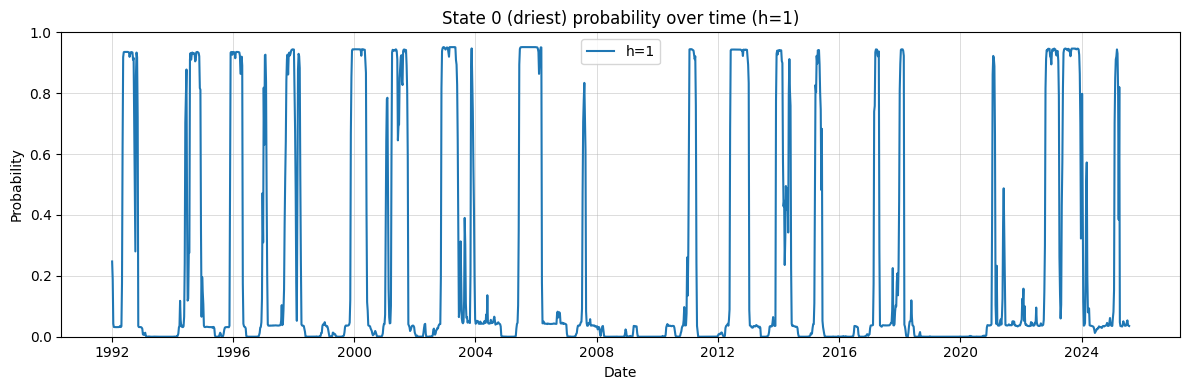

In [78]:
plot_state0_probs(data)

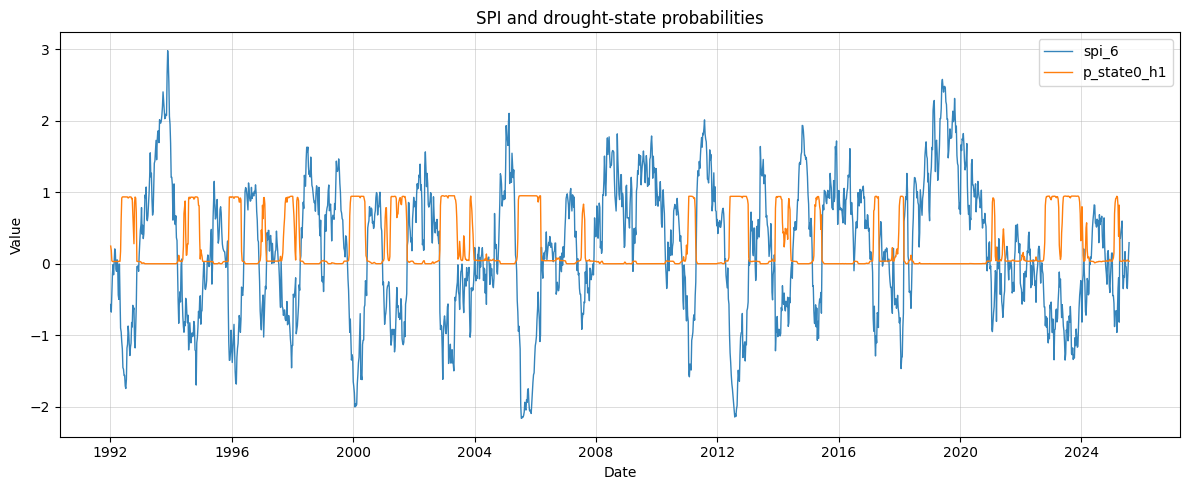

In [79]:
def plot_drought_prob_and_spi(results: pd.DataFrame,
                              date_col: str = "date",
                              spi_col: str = "spi_6",
                              prob_cols=("p_state0_h1",),   # default: only h=1
                              start_date=None,
                              figsize=(12, 5)):

    # Coerce prob_cols to a tuple even if a single string was passed
    if isinstance(prob_cols, str):
        prob_cols = (prob_cols,)
    else:
        prob_cols = tuple(str(c) for c in prob_cols)

    # Basic checks & prep
    if date_col not in results.columns:
        raise KeyError(f"Missing date column: {date_col}")
    if spi_col not in results.columns:
        raise KeyError(f"Missing SPI column: {spi_col}")

    df = results.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)
    if start_date is not None:
        df = df[df[date_col] >= pd.to_datetime(start_date)]

    # Find which requested prob columns exist
    avail_probs = [c for c in prob_cols if c in df.columns]
    if not avail_probs:
        existing_probs = [c for c in df.columns if c.startswith("p_state")]
        raise KeyError(
            f"None of the requested probability columns found: {prob_cols}. "
            f"Existing probability-like columns: {existing_probs}"
        )

    # Plot
    plt.figure(figsize=figsize)
    # SPI line -> blue
    plt.plot(df[date_col], df[spi_col], linewidth=1.0, alpha=0.9,
             label=spi_col, color="tab:blue")

    # First probability line -> orange (others, if any, default colors)
    for i, col in enumerate(avail_probs):
        kw = {"color": "tab:orange"} if i == 0 else {}
        plt.plot(df[date_col], df[col], linewidth=1.0, label=col, **kw)

    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title("SPI and drought-state probabilities")
    plt.grid(True, linewidth=0.5, alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_drought_prob_and_spi(data, prob_cols=("p_state0_h1",))

Next we want to show some of the metrics that help us determine how well the HMM is classifying and predicting weather states.

In [80]:

def spi_prob_lagged_corr(
    results: pd.DataFrame,
    spi_col: str = "spi_6",
    prob_cols: tuple[str, str] = ("p_state0_h1", "p_state0_h4"),
    date_col: str | None = "date",
    start_date: str = "1992-02-01",
    max_lag_weeks: int = 52,
) -> pd.DataFrame:
    """
    Correlate today's SPI with state-0 probabilities from the same day (lag=0)
    and from 1..max_lag_weeks weeks ago.

    Returns a DataFrame with columns:
      lag_weeks, corr_h1, n_h1, corr_h4, n_h4
    """
    df = results.copy()

    # Ensure we have a datetime index/column for filtering and sort by date
    if date_col and date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.sort_values(date_col).set_index(date_col)
    else:
        # assume index is already datetime-like
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError("Provide a datetime 'date' column or use a DatetimeIndex.")
        df = df.sort_index()

    # Keep only the needed columns & from start_date
    needed = [spi_col, *prob_cols]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required column(s): {missing}")

    df = df.loc[df.index >= pd.to_datetime(start_date), needed].copy()

    # Prepare output container
    out_rows = []
    h1, h4 = prob_cols

    # Compute correlations for lags 0..max_lag_weeks
    for lag in range(0, max_lag_weeks + 1):
        # Align: correlate SPI_t with prob_{t - lag}
        prob_h1_lag = df[h1].shift(lag)
        prob_h4_lag = df[h4].shift(lag)

        # Pairwise-drop NaNs per pair
        s_spi = df[spi_col]

        # h1
        mask_h1 = s_spi.notna() & prob_h1_lag.notna()
        corr_h1 = np.nan
        n_h1 = int(mask_h1.sum())
        if n_h1 >= 2:
            corr_h1 = float(s_spi[mask_h1].corr(prob_h1_lag[mask_h1]))

        # h4
        mask_h4 = s_spi.notna() & prob_h4_lag.notna()
        corr_h4 = np.nan
        n_h4 = int(mask_h4.sum())
        if n_h4 >= 2:
            corr_h4 = float(s_spi[mask_h4].corr(prob_h4_lag[mask_h4]))

        out_rows.append({
            "lag_weeks": lag,
            "corr_h1": corr_h1,
            "n_h1": n_h1,
            "corr_h4": corr_h4,
            "n_h4": n_h4,
        })

    out = pd.DataFrame(out_rows).set_index("lag_weeks")
    return out

# ---- usage ----


In [97]:
 corr_table = spi_prob_lagged_corr(results)
 corr_table.head(), corr_table.loc[[0,1,4,12,26,52]]
# If you want the best (most negative/positive) lag quickly:
# best_neg_h1 = corr_table['corr_h1'].idxmin()
# best_pos_h1 = corr_table['corr_h1'].idxmax()
# best_neg_h4 = corr_table['corr_h4'].idxmin()
# best_pos_h4 = corr_table['corr_h4'].idxmax()




(            corr_h1  n_h1   corr_h4  n_h4
 lag_weeks                                
 0         -0.679256  1748 -0.760197  1748
 1         -0.651977  1747 -0.730068  1747
 2         -0.624295  1746 -0.699509  1746
 3         -0.596803  1745 -0.669441  1745
 4         -0.567680  1744 -0.637966  1744,
             corr_h1  n_h1   corr_h4  n_h4
 lag_weeks                                
 0         -0.679256  1748 -0.760197  1748
 1         -0.651977  1747 -0.730068  1747
 4         -0.567680  1744 -0.637966  1744
 12        -0.352281  1736 -0.400031  1736
 26         0.028177  1722  0.021548  1722
 52         0.032633  1696  0.035189  1696)

Next we define a function that prepares our data to be calculate in the metrics.

In [82]:
def add_spi3class_and_score(
    df: pd.DataFrame,
    *,
    spi_col: str = "spi_6",
    horizon: int = 2,                          # compare probs at t to SPI class at t+h
    prob_col_tpl: str = "p_state{state}_h{h}", # how your columns are named
    dry_thr: float = -0.5, #from -0.5 to 0.5 is the nearly normal area of SPI above or below is midly dry and wet
    wet_thr: float =  0.5,
    train_mask: pd.Series | np.ndarray | None = None,   # boolean mask used to learn mapping
    state_to_class: dict[int, int] | None = None        # optional manual mapping {state: 0/1/2}
):
    """
    Adds 3-class SPI labels and scores HMM classification for a given horizon.

    df must already contain the state-probability columns for the chosen horizon, e.g.:
      p_state0_h1, p_state1_h1, p_state2_h1  (for horizon=1)

    Returns:
      metrics: dict with accuracy, confusion matrix, per-class report, brier-ish score,
               log loss (if all probs > 0), and the inferred state->class mapping.
      df: with new columns:
            - 'spi3' (0=dry,1=neutral,2=wet) at time t
            - 'spi3_tplus{h}' target labels at time t+h
            - 'pred3_{h}' argmax class predicted at time t
            - 'proba3_{h}_dry', 'proba3_{h}_neutral', 'proba3_{h}_wet'
    """
    C = 3
    h = horizon

    # 0) Build SPI -> 3-class labels at t and t+h
    def spi_to_3(spi):
        y = np.full_like(spi, 1, dtype=int)   # neutral
        y[spi <= dry_thr] = 0                 # dry
        y[spi >=  wet_thr] = 2               # wet
        return y

    df = df.copy()
    df["spi3"] = spi_to_3(df[spi_col].to_numpy())
    df[f"spi3_tplus{h}"] = df["spi3"].shift(-h)   # target at t+h

    # 1) Collect the K=3 probability columns for this horizon
    prob_cols = [prob_col_tpl.format(state=s, h=h) for s in range(3)]
    for c in prob_cols:
        if c not in df.columns:
            raise ValueError(f"Missing column: {c}")

    P = df[prob_cols].to_numpy()  # shape (T, 3), rows sum ~1
    T, K = P.shape
    assert K == 3, "This helper assumes K=3 states."

    # 2) Learn or use a mapping: state -> class (0=dry,1=neutral,2=wet)
    #    If not provided, infer on the training slice by ordering states by mean SPI
    #    (lowest mean -> dry, middle -> neutral, highest -> wet).
    if state_to_class is None:
        if train_mask is None:
            # default: use all non-na rows up to where target exists
            train_mask = pd.Series(True, index=df.index)
        else:
            train_mask = pd.Series(train_mask, index=df.index)

        # Use only rows where SPI and probs exist AND target exists (avoid leakage)
        valid_train = train_mask & df[spi_col].notna() & (~df[f"spi3_tplus{h}"].isna())
        if valid_train.sum() < 10:
            # fallback: just order by overall mean if train slice too small
            valid_train = df[spi_col].notna()

        spi_vals = df.loc[valid_train, spi_col].to_numpy()
        P_train  = P[valid_train.to_numpy(), :]

        # weighted mean SPI per state (soft responsibilities)
        state_means = []
        for s in range(3):
            w = P_train[:, s]
            denom = w.sum()
            m = (w @ spi_vals) / denom if denom > 0 else np.inf
            state_means.append(m)

        # map by ascending mean: low -> dry(0), mid -> neutral(1), high -> wet(2)
        order = np.argsort(state_means)  # indices of states from driest to wettest
        inferred_mapping = {int(order[0]): 0, int(order[1]): 1, int(order[2]): 2}
        mapping = inferred_mapping
    else:
        mapping = dict(state_to_class)

    # 3) Aggregate state probabilities into class probabilities at time t
    proba3 = np.zeros((T, C), dtype=float)
    for s, c in mapping.items():
        proba3[:, c] += P[:, s]

    # 4) Hard prediction at time t (argmax over class probs)
    y_pred = proba3.argmax(axis=1)

    # 5) Targets are SPI class at t+h
    y_true = df[f"spi3_tplus{h}"].to_numpy()

    # 6) Keep only rows where target exists
    mask_eval = ~np.isnan(y_true)
    y_true = y_true[mask_eval].astype(int)
    y_pred_eval = y_pred[mask_eval]
    proba3_eval = proba3[mask_eval]

    # 7) Metrics
    acc = accuracy_score(y_true, y_pred_eval)
    cm  = confusion_matrix(y_true, y_pred_eval, labels=[0,1,2])
    report = classification_report(
        y_true, y_pred_eval, labels=[0,1,2],
        target_names=["dry","neutral","wet"], digits=3
    )

    # Brier-like score (mean squared error of the prob vector vs. one-hot)
    one_hot = np.eye(3)[y_true]
    brier = float(np.mean((proba3_eval - one_hot) ** 2))

    # log loss (guard against zeros)
    eps = 1e-12
    proba_safe = np.clip(proba3_eval, eps, 1 - eps)
    ll = log_loss(y_true, proba_safe, labels=[0,1,2])

    # 8) Attach columns
    df[f"proba3_{h}_dry"]     = proba3[:, 0]
    df[f"proba3_{h}_neutral"] = proba3[:, 1]
    df[f"proba3_{h}_wet"]     = proba3[:, 2]
    df[f"pred3_{h}"]          = y_pred

    metrics = {
        "horizon": h,
        "state_to_class": mapping,         # {state: 0/1/2}
        "accuracy": acc,
        "confusion_matrix": cm,
        "classification_report": report,
        "brier_like": brier,
        "log_loss": ll
    }
    return df, metrics


In [98]:
# ---------- Helpers ----------
def brier_score(y_true, proba):
    """Multi-class Brier (mean squared error vs. one-hot)."""
    one_hot = np.eye(proba.shape[1])[y_true]
    return float(np.mean((proba - one_hot) ** 2))

def brier_decomposition(y_true, proba):
    """
    Murphy (1973) decomposition: Brier = reliability - resolution + uncertainty
    Using equal-width bins per class (10 bins).
    """
    K = proba.shape[1]
    one_hot = np.eye(K)[y_true]
    p_bar = one_hot.mean(axis=0)  # climatological class frequencies
    uncertainty = float(np.sum(p_bar * (1 - p_bar)))  # sum_k p_k (1 - p_k)

    # Reliability & Resolution via per-class binning
    n_bins = 10
    reliability = 0.0
    resolution  = 0.0
    for k in range(K):
        pk = proba[:, k]
        yk = one_hot[:, k]
        bins = np.linspace(0, 1, n_bins + 1)
        idx = np.digitize(pk, bins) - 1  # 0..n_bins-1
        for b in range(n_bins):
            mask = idx == b
            if not np.any(mask):
                continue
            p_bin = pk[mask].mean()
            o_bin = yk[mask].mean()
            w = mask.mean()
            reliability += w * (p_bin - o_bin) ** 2
        # Resolution is variance of conditional event rate around climatology
        # (approximate by grouping using same bins)
        o_vals = []
        w_vals = []
        for b in range(n_bins):
            mask = idx == b
            if not np.any(mask):
                continue
            o_vals.append(yk[mask].mean())
            w_vals.append(mask.mean())
        if o_vals:
            o_vals = np.array(o_vals)
            w_vals = np.array(w_vals)
            resolution += float(np.sum(w_vals * (o_vals - p_bar[k]) ** 2))

    return {
        "brier": reliability - resolution + uncertainty,
        "reliability": float(reliability),
        "resolution": float(resolution),
        "uncertainty": float(uncertainty),
    }

def ranked_probability_score(y_true, proba):
    """
    RPS for ordered 3 classes (0=dry,1=neutral,2=wet).
    RPS = sum_{k=1..K-1} (CDF_forecast(k) - CDF_obs(k))^2
    """
    K = proba.shape[1]
    one_hot = np.eye(K)[y_true]
    cdf_f = np.cumsum(proba, axis=1)
    cdf_o = np.cumsum(one_hot, axis=1)
    # exclude last CDF step (always 1)
    diff = cdf_f[:, :K-1] - cdf_o[:, :K-1]
    return float(np.mean(np.sum(diff**2, axis=1)))

def ranked_probability_skill_score(y_true, proba, climatology):
    """
    RPSS = 1 - RPS_forecast / RPS_climatology
    climatology: length-K vector of class frequencies
    """
    K = proba.shape[1]
    P_clim = np.broadcast_to(climatology.reshape(1, K), proba.shape)
    rps_f = ranked_probability_score(y_true, proba)
    rps_c = ranked_probability_score(y_true, P_clim)
    return float(1.0 - rps_f / rps_c) if rps_c > 0 else np.nan

def expected_calibration_error(y_true, proba, n_bins=10):
    """
    Multiclass ECE (OvR): average (weighted by bin size) gap between predicted prob
    and empirical frequency, averaged over classes and bins.
    """
    K = proba.shape[1]
    one_hot = np.eye(K)[y_true]
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    mce = 0.0
    total = len(y_true)
    # Keep a reliability table too
    rows = []
    for k in range(K):
        pk = proba[:, k]
        yk = one_hot[:, k]
        idx = np.digitize(pk, bins) - 1
        for b in range(n_bins):
            mask = idx == b
            count = mask.sum()
            if count == 0:
                continue
            conf = pk[mask].mean()
            acc  = yk[mask].mean()  # empirical freq of class k in the bin
            gap = abs(conf - acc)
            weight = count / total
            ece += weight * gap
            mce = max(mce, gap)
            rows.append({
                "class": k, "bin": b,
                "count": int(count),
                "mean_confidence": float(conf),
                "empirical_freq": float(acc),
                "gap": float(gap),
            })
    calib_table = pd.DataFrame(rows)
    return float(ece), float(mce), calib_table

def entropy(proba, eps=1e-12):
    p = np.clip(proba, eps, 1 - eps)
    return float(-np.mean(np.sum(p * np.log(p), axis=1)))

def binary_event_metrics(y_true, proba, positive_class, threshold=0.5):
    """
    Treat a given class as an 'event' vs the rest.
    Returns precision, recall, f1, TSS (Peirce), hit rate, false alarm ratio.
    """
    y_bin_true = (y_true == positive_class).astype(int)
    y_bin_prob = proba[:, positive_class]
    y_bin_pred = (y_bin_prob >= threshold).astype(int)

    # Confusion terms
    TP = int(np.sum((y_bin_true == 1) & (y_bin_pred == 1)))
    FP = int(np.sum((y_bin_true == 0) & (y_bin_pred == 1)))
    TN = int(np.sum((y_bin_true == 0) & (y_bin_pred == 0)))
    FN = int(np.sum((y_bin_true == 1) & (y_bin_pred == 0)))

    prec = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    rec  = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1   = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0

    # Hit rate (POD/recall) and False Alarm Ratio (FAR)
    hit_rate = rec
    far = FP / (TP + FP) if (TP + FP) > 0 else 0.0

    # True Skill Statistic (Peirce) = TPR - FPR
    tpr = rec
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0.0
    tss = tpr - fpr

    return {
        "threshold": threshold,
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "hit_rate": float(hit_rate),
        "false_alarm_ratio": float(far),
        "tss": float(tss),
        "confusion": {"TP": TP, "FP": FP, "TN": TN, "FN": FN}
    }

def persistence_baseline(y_true_full, y_pred_at_t_full, mask_eval):
    """
    Persistence for h>0: predict class at t+h as class at t.
    y_pred_at_t_full: class at t (e.g., df['spi3'].values)
    y_true_full:      class at t+h (e.g., df[f'spi3_tplus{h}'].values)
    mask_eval:        boolean mask used in add_spi3class_and_score
    """
    y_true = y_true_full[mask_eval].astype(int)
    y_pers = y_pred_at_t_full[mask_eval].astype(int)
    acc = accuracy_score(y_true, y_pers)
    cm = confusion_matrix(y_true, y_pers, labels=[0,1,2])
    return float(acc), cm

# ---------- Main augmentor ----------
def enrich_hmm_metrics(df_scored: pd.DataFrame, metrics: dict, *,
                       horizon: int,
                       spi_col: str = "spi_6",
                       dry_class=0, neutral_class=1, wet_class=2,
                       event_threshold: float = 0.5,
                       train_mask: pd.Series | np.ndarray | None = None):
    """
    Takes the outputs from add_spi3class_and_score (df_scored, metrics)
    and adds: RPS/RPSS, calibration (ECE/MCE + reliability table), OvR ROC-AUC & PR-AUC,
    event metrics for dry & wet, baselines (climatology & persistence), entropy, and brier decomposition.
    """
    h = horizon
    # Extract evaluation slice from earlier function
    y_true_full = df_scored[f"spi3_tplus{h}"].to_numpy()
    proba = np.vstack([
        df_scored[f"proba3_{h}_dry"].to_numpy(),
        df_scored[f"proba3_{h}_neutral"].to_numpy(),
        df_scored[f"proba3_{h}_wet"].to_numpy()
    ]).T
    y_pred_at_t_full = df_scored["spi3"].to_numpy()  # persistence anchor

    mask_eval = ~np.isnan(y_true_full)
    y_true = y_true_full[mask_eval].astype(int)
    proba_eval = proba[mask_eval]

    # --- Climatology (by training slice if provided, else by eval slice) ---
    if train_mask is None:
        clim_counts = np.bincount(y_true, minlength=3).astype(float)
    else:
        m = pd.Series(train_mask, index=df_scored.index).fillna(False).to_numpy()
        # make sure target exists in training to avoid leakage
        m = m & (~np.isnan(y_true_full))
        clim_counts = np.bincount(y_true_full[m].astype(int), minlength=3).astype(float)
        if clim_counts.sum() == 0:
            clim_counts = np.bincount(y_true, minlength=3).astype(float)
    clim_freq = clim_counts / clim_counts.sum() if clim_counts.sum() > 0 else np.array([1/3,1/3,1/3])

    # --- Proper scores & calibration ---
    ll = log_loss(y_true, np.clip(proba_eval, 1e-12, 1-1e-12), labels=[0,1,2])
    bs = brier_score(y_true, proba_eval)
    bd = brier_decomposition(y_true, proba_eval)

    rps  = ranked_probability_score(y_true, proba_eval)
    rpss = ranked_probability_skill_score(y_true, proba_eval, climatology=clim_freq)

    ece, mce, calib_table = expected_calibration_error(y_true, proba_eval, n_bins=10)
    sharpness_entropy = entropy(proba_eval)

    # --- Discrimination: OvR AUCs ---
    auc_ovr = {}
    ap_ovr  = {}
    for c, name in zip([dry_class, neutral_class, wet_class], ["dry","neutral","wet"]):
        y_bin = (y_true == c).astype(int)
        auc_ovr[name] = float(roc_auc_score(y_bin, proba_eval[:, c]))
        ap_ovr[name]  = float(average_precision_score(y_bin, proba_eval[:, c]))

    # --- Event metrics for dry and wet at a working threshold ---
    dry_event = binary_event_metrics(y_true, proba_eval, positive_class=dry_class, threshold=event_threshold)
    wet_event = binary_event_metrics(y_true, proba_eval, positive_class=wet_class, threshold=event_threshold)

    # --- Baselines ---
    # climatology 'accuracy' via random draw isn't well-defined; report log loss & RPS baseline instead
    # persistence accuracy:
    acc_persist, cm_persist = persistence_baseline(y_true_full, y_pred_at_t_full, mask_eval)

    # Package everything
    extra = {
        "proper_scores": {
            "log_loss": float(ll),
            "brier": float(bs),
            "brier_decomposition": bd,  # reliability, resolution, uncertainty
            "rps": float(rps),
            "rpss_vs_climatology": float(rpss),
        },
        "calibration": {
            "ece": float(ece),
            "mce": float(mce),
            "reliability_table": calib_table,  # DataFrame
        },
        "discrimination": {
            "roc_auc_ovr": auc_ovr,
            "pr_auc_ovr": ap_ovr,
        },
        "events": {
            "dry": dry_event,
            "wet": wet_event,
            "threshold_used": float(event_threshold),
        },
        "baselines": {
            "climatology_class_freq": clim_freq.tolist(),
            "persistence_accuracy": float(acc_persist),
            "persistence_confusion_matrix": cm_persist,
        },
        "sharpness": {
            "mean_entropy": float(sharpness_entropy)
        }
    }
    # Merge into your original metrics dict (don’t overwrite existing keys)
    out = metrics.copy()
    out.update(extra)
    return out


In [99]:
# You already have:
df_scored, m1 = add_spi3class_and_score(
    df=data,
    spi_col="spi_6",
    horizon=1,
    prob_col_tpl="p_state{state}_h{h}",
    # train_mask=...  # optional
)

m1_full = enrich_hmm_metrics(
    df_scored, m1, horizon=1, spi_col="spi_6",
    event_threshold=0.5,
    train_mask=None  # or your per-block training slice to set climatology
)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [100]:
#Example: evaluate 1-week-ahead classification using columns p_state{0,1,2}_h1
df_scored, m1 = add_spi3class_and_score(
    data,
    spi_col="spi_6",
    horizon=1,
    prob_col_tpl="p_state{state}_h1",
    # train_mask = weekly_spi.index < pd.Timestamp("1992-01-05")  # e.g., per-block
)

print(m1["state_to_class"])        # mapping state -> {0=dry,1=neutral,2=wet}
print(m1["accuracy"])
print(m1["classification_report"])
print(m1["confusion_matrix"])

# For 4-week-ahead, just change horizon
#_, m4 = add_spi3class_and_score(weekly_spi, spi_col="spi_6", horizon=4)


{0: 0, 1: 1, 2: 2}
0.6647629925756711
              precision    recall  f1-score   support

         dry      0.957     0.484     0.642       457
     neutral      0.529     0.435     0.478       600
         wet      0.664     0.983     0.793       694

    accuracy                          0.665      1751
   macro avg      0.717     0.634     0.638      1751
weighted avg      0.694     0.665     0.645      1751

[[221 220  16]
 [ 10 261 329]
 [  0  12 682]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [101]:
# === ANSI color helpers ===
def green(text): return f"\033[92m{text}\033[0m"
def red(text):   return f"\033[91m{text}\033[0m"
def yellow(text):return f"\033[93m{text}\033[0m"

def explain_metrics(metrics: dict):
    """
    Pretty-print the enriched HMM metrics with explanations and color-coded
    good (green) / bad (red) values based on heuristic thresholds.
    """
    print("=== HMM Forecast Performance Summary ===\n")

    # --- Basic accuracy ---
    acc = metrics["accuracy"]
    acc_txt = green(f"{acc:.3f}") if acc >= 0.7 else red(f"{acc:.3f}")
    print(f"Accuracy: {acc_txt} → Predicted class matches true class {acc*100:.1f}% of the time.\n")

    # --- Proper scoring rules ---
    ps = metrics["proper_scores"]
    ll = ps["log_loss"]
    ll_txt = green(f"{ll:.3f}") if ll < 0.7 else red(f"{ll:.3f}")
    print("Proper Scoring Rules:")
    print(f"  Log Loss: {ll_txt} → Penalizes overconfident wrong forecasts (lower is better). "
          f"(Climatology ~1.1 for 3 classes)")

    brier = ps["brier"]
    brier_txt = green(f"{brier:.3f}") if brier < 0.25 else red(f"{brier:.3f}")
    print(f"  Brier Score: {brier_txt} → Mean squared error of forecast probabilities vs. outcomes (0=perfect).")
    bd = ps["brier_decomposition"]
    print(f"    • Reliability: {bd['reliability']:.3f} → Closeness of probs to observed frequencies.")
    print(f"    • Resolution:  {bd['resolution']:.3f} → Ability to distinguish situations.")
    print(f"    • Uncertainty: {bd['uncertainty']:.3f} → Inherent variability of classes.")

    rps = ps["rps"]
    rps_txt = green(f"{rps:.3f}") if rps < 0.2 else red(f"{rps:.3f}")
    rpss = ps["rpss_vs_climatology"]
    rpss_txt = green(f"{rpss:.3f}") if rpss > 0.2 else (yellow(f"{rpss:.3f}") if rpss > 0 else red(f"{rpss:.3f}"))
    print(f"  Ranked Probability Score (RPS): {rps_txt} → Lower is better (climatology ~0.33).")
    print(f"  Ranked Probability Skill Score (RPSS): {rpss_txt} → Skill vs climatology (>0 is better).\n")

    # --- Calibration ---
    cal = metrics["calibration"]
    ece = cal["ece"]; mce = cal["mce"]
    ece_txt = green(f"{ece:.3f}") if ece < 0.1 else red(f"{ece:.3f}")
    mce_txt = green(f"{mce:.3f}") if mce < 0.2 else red(f"{mce:.3f}")
    print("Calibration:")
    print(f"  Expected Calibration Error (ECE): {ece_txt} → Average mismatch between forecasted probability and reality.")
    print(f"  Maximum Calibration Error (MCE): {mce_txt} → Worst-case mismatch across bins.\n")

    # --- Discrimination (ROC-AUC / PR-AUC) ---
    print("Discrimination (One-vs-Rest AUCs):")
    for cls, auc in metrics["discrimination"]["roc_auc_ovr"].items():
        ap = metrics["discrimination"]["pr_auc_ovr"][cls]
        auc_txt = green(f"{auc:.3f}") if auc > 0.7 else red(f"{auc:.3f}")
        ap_txt  = green(f"{ap:.3f}")  if ap > 0.5 else red(f"{ap:.3f}")
        print(f"  {cls.capitalize()}: ROC-AUC={auc_txt}, PR-AUC={ap_txt} → Ability to separate {cls} from others.\n")

    # --- Event metrics ---
    print("Event-style metrics (threshold-based alerts):")
    for ev in ["dry", "wet"]:
        em = metrics["events"][ev]
        tss = em["tss"]
        tss_txt = green(f"{tss:.3f}") if tss > 0.3 else red(f"{tss:.3f}")
        prec_txt = green(f"{em['precision']:.3f}") if em['precision'] > 0.5 else red(f"{em['precision']:.3f}")
        rec_txt  = green(f"{em['recall']:.3f}")    if em['recall'] > 0.5 else red(f"{em['recall']:.3f}")
        print(f"  {ev.capitalize()} event (threshold {em['threshold']}):")
        print(f"    Precision={prec_txt} → Of predicted {ev} events, {em['precision']*100:.1f}% were correct.")
        print(f"    Recall/Hit Rate={rec_txt} → Captured {em['recall']*100:.1f}% of actual {ev} events.")
        print(f"    TSS={tss_txt} → Balances hits vs false alarms (0=no skill, 1=perfect).\n")

    # --- Baselines ---
    base = metrics["baselines"]
    acc_persist = base["persistence_accuracy"]
    pers_txt = green(f"{acc_persist:.3f}") if acc_persist > 0.6 else red(f"{acc_persist:.3f}")
    print("Baselines:")
    print(f"  Persistence accuracy: {pers_txt} → Using today’s class to predict {base['persistence_accuracy']*100:.1f}% correctly.")
    clim = base["climatology_class_freq"]
    print(f"  Climatology frequencies: Dry={clim[0]:.2f}, Neutral={clim[1]:.2f}, Wet={clim[2]:.2f}.\n")

    # --- Sharpness ---
    sharp = metrics["sharpness"]["mean_entropy"]
    sharp_txt = green(f"{sharp:.3f}") if sharp < 0.8 else red(f"{sharp:.3f}")
    print("Sharpness:")
    print(f"  Mean entropy: {sharp_txt} → Forecast uncertainty; lower = sharper, more confident.\n")

    print("=== End of Report ===")


The one troubling statistics is the Maximum Calibration Error (MCE): 0.436, but this effectively looks at the probability bins so I'd say for my needs where I just want the final class prediction, precision is more important.

In [102]:
df_scored, m1 = add_spi3class_and_score(
    df=data,
    spi_col="spi_6",
    horizon=1,
    prob_col_tpl="p_state{state}_h{h}"
)

m1_full = enrich_hmm_metrics(df_scored, m1, horizon=1)
explain_metrics(m1_full)

=== HMM Forecast Performance Summary ===

Accuracy: 0.665 → Predicted class matches true class 66.5% of the time.

Proper Scoring Rules:
  Log Loss: 1.672 → Penalizes overconfident wrong forecasts (lower is better). (Climatology ~1.1 for 3 classes)
  Brier Score: 0.249 → Mean squared error of forecast probabilities vs. outcomes (0=perfect).
    • Reliability: 0.234 → Closeness of probs to observed frequencies.
    • Resolution:  0.126 → Ability to distinguish situations.
    • Uncertainty: 0.657 → Inherent variability of classes.
  Ranked Probability Score (RPS): 0.287 → Lower is better (climatology ~0.33).
  Ranked Probability Skill Score (RPSS): 0.337 → Skill vs climatology (>0 is better).

Calibration:
  Expected Calibration Error (ECE): 0.718 → Average mismatch between forecasted probability and reality.
  Maximum Calibration Error (MCE): 0.709 → Worst-case mismatch across bins.

Discrimination (One-vs-Rest AUCs):
  Dry: ROC-AUC=0.967, PR-AUC=0.916 → Ability to separate dry from ot

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Robustness of results over smaller bins of the sample.

In [88]:
# Split DataFrame `data` into 5 chronologically continuous bins (equal time span)

import pandas as pd, numpy as np

date_col = "date"

x = data.copy()
x[date_col] = pd.to_datetime(x[date_col])
x = x.sort_values(date_col).reset_index(drop=True)

start = x[date_col].min()
end   = x[date_col].max()

# 6 cut points (inclusive endpoints) → 5 bins
edges = pd.to_datetime(np.linspace(start.value, end.value, 6).astype("int64"))

mask1 = (x[date_col] >= edges[0]) & (x[date_col] <  edges[1])
mask2 = (x[date_col] >= edges[1]) & (x[date_col] <  edges[2])
mask3 = (x[date_col] >= edges[2]) & (x[date_col] <  edges[3])
mask4 = (x[date_col] >= edges[3]) & (x[date_col] <  edges[4])
mask5 = (x[date_col] >= edges[4]) & (x[date_col] <= edges[5])  # include last endpoint

data1 = x.loc[mask1].copy()
data2 = x.loc[mask2].copy()
data3 = x.loc[mask3].copy()
data4 = x.loc[mask4].copy()
data5 = x.loc[mask5].copy()

bins = [data1, data2, data3, data4, data5]
print("Bin ranges:")
for i in range(5):
    print(f"data{i+1}: {edges[i].date()} — {edges[i+1].date()} (rows={len(bins[i])})")
# OPTIONAL: If you want fixed calendar edges (edit these 6 dates, first..last)
# Example: 1992→2002→2008→2014→2020→end
edges = pd.to_datetime([
    "1992-01-01", "2002-01-01", "2008-01-01", "2014-01-01", "2020-01-01", x[date_col].max().strftime("%Y-%m-%d")
])

mask1 = (x[date_col] >= edges[0]) & (x[date_col] <  edges[1])
mask2 = (x[date_col] >= edges[1]) & (x[date_col] <  edges[2])
mask3 = (x[date_col] >= edges[2]) & (x[date_col] <  edges[3])
mask4 = (x[date_col] >= edges[3]) & (x[date_col] <  edges[4])
mask5 = (x[date_col] >= edges[4]) & (x[date_col] <= edges[5])

data1 = x.loc[mask1].copy()
data2 = x.loc[mask2].copy()
data3 = x.loc[mask3].copy()
data4 = x.loc[mask4].copy()
data5 = x.loc[mask5].copy()


Bin ranges:
data1: 1992-01-05 — 1998-09-21 (rows=351)
data2: 1998-09-21 — 2005-06-07 (rows=350)
data3: 2005-06-07 — 2012-02-23 (rows=350)
data4: 2012-02-23 — 2018-11-09 (rows=350)
data5: 2018-11-09 — 2025-07-27 (rows=351)


In [93]:
for data in [data1, data2, data3, data4, data5]:
  df_scored, m1 = add_spi3class_and_score(
    df=data,
    spi_col="spi_6",
    horizon=1,
    prob_col_tpl="p_state{state}_h{h}"
  )

  m1_full = enrich_hmm_metrics(df_scored, m1, horizon=1)
  explain_metrics(m1_full)

=== HMM Forecast Performance Summary ===

Accuracy: 0.795 → Predicted class matches true class 79.5% of the time.

Proper Scoring Rules:
  Log Loss: 0.526 → Penalizes overconfident wrong forecasts (lower is better). (Climatology ~1.1 for 3 classes)
  Brier Score: 0.104 → Mean squared error of forecast probabilities vs. outcomes (0=perfect).
    • Reliability: 0.059 → Closeness of probs to observed frequencies.
    • Resolution:  0.406 → Ability to distinguish situations.
    • Uncertainty: 0.665 → Inherent variability of classes.
  Ranked Probability Score (RPS): 0.160 → Lower is better (climatology ~0.33).
  Ranked Probability Skill Score (RPSS): 0.649 → Skill vs climatology (>0 is better).

Calibration:
  Expected Calibration Error (ECE): 0.250 → Average mismatch between forecasted probability and reality.
  Maximum Calibration Error (MCE): 0.573 → Worst-case mismatch across bins.

Discrimination (One-vs-Rest AUCs):
  Dry: ROC-AUC=0.964, PR-AUC=0.932 → Ability to separate dry from ot

Below are key metrics displayed comparartively across blocks.

In [90]:

import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.metrics import f1_score

# ---- thresholds (tune these as you like) ----
ACC_GOOD    = 0.65   # higher is better
F1_GOOD     = 0.60   # higher is better
BRIER_BAD   = 0.25   # lower is better
LOGLOSS_BAD = 0.70   # lower is better

def color_high_good(v, thr):
    if pd.isna(v): return ""
    return "background-color: green; color: white;" if v >= thr else "background-color: red; color: white;"

def color_low_good(v, thr):
    if pd.isna(v): return ""
    return "background-color: green; color: white;" if v <= thr else "background-color: red; color: white;"

# --- ensure your 5 blocks exist: data1..data5 (each has 'date','spi_6', and p_state{0,1,2}_h1) ---
blocks = [("data1", data1), ("data2", data2), ("data3", data3), ("data4", data4), ("data5", data5)]

rows = []
for name, block in blocks:
    # Score this block at horizon h=1 using your existing helper
    df_scored, m = add_spi3class_and_score(
        block,
        spi_col="spi_6",
        horizon=1,
        prob_col_tpl="p_state{state}_h{h}",
        # optionally pass a train_mask here if you want mapping learned only on a subset
    )

    # Compute macro-F1 from the scored DataFrame
    mask_eval = df_scored["spi3_tplus1"].notna()
    y_true = df_scored.loc[mask_eval, "spi3_tplus1"].astype(int)
    y_pred = df_scored.loc[mask_eval, "pred3_1"].astype(int)
    macro_f1 = f1_score(y_true, y_pred, labels=[0,1,2], average="macro")

    # Block meta
    start = pd.to_datetime(block["date"]).min()
    end   = pd.to_datetime(block["date"]).max()

    rows.append({
        "Block": name,
        "Start": start.date(),
        "End": end.date(),
        "Rows": int(len(block)),
        "n_eval": int(mask_eval.sum()),
        "Accuracy": float(m["accuracy"]),
        "Macro F1": float(macro_f1),
        "Brier": float(m["brier_like"]),
        "LogLoss": float(m["log_loss"]),
    })

summary = pd.DataFrame(rows)

# ---- ABSOLUTE coloring (not comparative across blocks) ----
styler = (
    summary.style
        .format({
            "Accuracy": "{:.3f}",
            "Macro F1": "{:.3f}",
            "Brier": "{:.4f}",
            "LogLoss": "{:.4f}",
        })
        # Higher is better:
        .applymap(lambda v: color_high_good(v, ACC_GOOD), subset=["Accuracy"])
        .applymap(lambda v: color_high_good(v, F1_GOOD),  subset=["Macro F1"])
        # Lower is better:
        .applymap(lambda v: color_low_good(v, BRIER_BAD), subset=["Brier"])
        .applymap(lambda v: color_low_good(v, LOGLOSS_BAD), subset=["LogLoss"])
        .set_properties(subset=["Start", "End", "Block"], **{"white-space": "nowrap"})
        .set_caption("Block-wise classification metrics (absolute thresholds: green=good, red=bad)")
)

display(styler)


/tmp/ipython-input-413336101.py:68: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda v: color_high_good(v, ACC_GOOD), subset=["Accuracy"])
/tmp/ipython-input-413336101.py:69: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda v: color_high_good(v, F1_GOOD),  subset=["Macro F1"])
/tmp/ipython-input-413336101.py:71: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda v: color_low_good(v, BRIER_BAD), subset=["Brier"])
/tmp/ipython-input-413336101.py:72: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda v: color_low_good(v, LOGLOSS_BAD), subset=["LogLoss"])


,Block,Start,End,Rows,n_eval,Accuracy,Macro F1,Brier,LogLoss
0,data1,1992-01-05,2001-12-30,522,521,0.795,0.793,0.1044,0.5257
1,data2,2002-01-06,2007-12-30,313,312,0.846,0.846,0.0784,0.4165
2,data3,2008-01-06,2013-12-29,313,312,0.840,0.821,0.0836,0.4335
3,data4,2014-01-05,2019-12-29,313,312,0.798,0.734,0.0969,0.4927
4,data5,2020-01-05,2025-07-27,291,290,0.800,0.794,0.1015,0.5135


I had doubts for using BIC to determine grid search of K - because it doesnt really optimize for predictive ability so it suggests K=4 which is actually less accurate in its predictions than K=3. Thus I thought of using logloss and F1 for grid search. That code is here.

In [103]:
# =========================
# Predictive model selection for K (task-aligned)
# =========================
import numpy as np
from sklearn.metrics import log_loss, f1_score

def _spi_to_3(spi, dry_thr=-0.5, wet_thr=0.5):
    y = np.full_like(spi, 1, dtype=int)   # neutral
    y[spi <= dry_thr] = 0                 # dry
    y[spi >=  wet_thr] = 2                # wet
    return y

def fit_best_hmm_1d_predictive(
    X_all: np.ndarray,
    dates,                      # pd.Series[Timestamp] aligned to X_all
    spi_all: np.ndarray,        # same length as X_all
    b_start,                    # pd.Timestamp for block start (train prefix: dates < b_start)
    cfg: HMMCfg,
    *,
    horizons=(1,),              # e.g., (1,4)
    val_weeks=104,              # ~2 years validation from the end of train prefix
    dry_thr=-0.5,
    wet_thr=0.5,
    random_state_extra: int = 0 # optional jitter to seeds per block
) -> GaussianHMM:
    """
    Select K by validation forecast log-loss averaged across `horizons`.
    Returns final model refit on the full train prefix with the chosen K
    (states reordered by ascending mean).
    """
    X_all = np.asarray(X_all).reshape(-1, 1)
    if not np.isfinite(X_all).all():
        raise ValueError("X_all contains NaN/Inf")
    if len(X_all) != len(spi_all):
        raise ValueError("X_all and spi_all must have the same length")

    # Indices of the train prefix
    mask_train_full = (dates < b_start)
    idx_train_full = np.where(mask_train_full)[0]
    if len(idx_train_full) < 80:
        raise ValueError(f"Not enough training data before {b_start.date()} (got {len(idx_train_full)})")

    # Validation split from the tail of the train prefix
    v = min(val_weeks, max(0, len(idx_train_full) - 50))  # keep ≥50 weeks for core training
    idx_val = idx_train_full[-v:] if v > 0 else np.array([], dtype=int)
    idx_tr  = idx_train_full[:-v] if v > 0 else idx_train_full

    # Precompute true classes at t and t+h (aligned to row t)
    y_t = _spi_to_3(spi_all, dry_thr, wet_thr)
    y_tplus = {h: np.where(np.arange(len(y_t)) <= len(y_t)-1-h, y_t[h:], -1) for h in horizons}

    best_key = None
    best_scores = None
    best_model_seeded = None

    for K in cfg.K_grid:
        # ============ fit on core training (exclude validation) with multiple restarts ============
        best_ll, best_m = -np.inf, None
        X_tr = X_all[idx_tr] if len(idx_tr) > 0 else X_all[idx_train_full]
        for s in range(cfg.n_init):
            m = GaussianHMM(
                n_components=K,
                covariance_type=cfg.covariance_type,
                n_iter=cfg.max_iter,
                random_state=(cfg.random_state + random_state_extra + s)
            )
            m.fit(X_tr)
            ll = m.score(X_tr)
            if ll > best_ll:
                best_ll, best_m = ll, m

        # Reorder states by ascending emission mean (stabilizes mapping)
        best_m = reorder_states_by_mean(best_m)

        # ============ build state->class mapping on training via weighted SPI means ============
        # Use only training indices (exclude validation to avoid leakage)
        G_tr = []
        for t in idx_tr:
            G_tr.append(best_m.predict_proba(X_all[:t+1])[-1])  # causal g_t on training
        G_tr = np.array(G_tr) if len(G_tr) else np.zeros((0, K))
        spi_tr = spi_all[idx_tr]
        state_means = []
        for s_idx in range(K):
            w = G_tr[:, s_idx] if len(G_tr) else np.array([])
            denom = w.sum()
            m_spi = (w @ spi_tr)/denom if denom > 0 else np.inf
            state_means.append(m_spi)
        order = np.argsort(state_means)  # driest -> wettest by SPI mean

        # Map K states to 3 classes by grouping the rank order into 3 buckets
        buckets = np.array_split(order, 3)
        state_to_class = {int(s): i for i, grp in enumerate(buckets) for s in grp}

        # ============ evaluate on validation: causal g_t, then h-step forecast, then class proba ============
        # If no validation slice, skip scoring (fallback later)
        per_h = []
        per_h_F1 = []

        if len(idx_val) > 0:
            T = best_m.transmat_
            Th_cache = {h: T_power(T, h) for h in horizons}

            y_true_all = []
            y_pred_proba_all = []

            for t in idx_val:
                g_t = best_m.predict_proba(X_all[:t+1])[-1]   # (K,)
                for h in horizons:
                    y_true = y_tplus[h][t]
                    if y_true == -1:   # no valid target
                        continue
                    g_th = g_t @ Th_cache[h]                  # (K,)
                    proba3 = np.zeros(3, dtype=float)
                    for s_idx, c in state_to_class.items():
                        proba3[c] += g_th[s_idx]
                    y_true_all.append(int(y_true))
                    y_pred_proba_all.append(proba3)

            if len(y_true_all) > 0:
                y_true_all = np.array(y_true_all)
                y_pred_proba_all = np.vstack(y_pred_proba_all)
                # primary score: multiclass log-loss (proper scoring, threshold-free)
                ll = log_loss(y_true_all, np.clip(y_pred_proba_all, 1e-12, 1-1e-12), labels=[0,1,2])
                per_h.append(ll)
                # tie-breaker: macro-F1 on argmax decisions
                y_pred_arg = y_pred_proba_all.argmax(axis=1)
                per_h_F1.append(f1_score(y_true_all, y_pred_arg, labels=[0,1,2], average="macro"))

        # Aggregate (if no validation, set inf so we’ll fall back later)
        val_ll = float(np.mean(per_h)) if per_h else np.inf
        val_f1 = float(np.mean(per_h_F1)) if per_h_F1 else -np.inf

        key = (val_ll, -val_f1, K)  # lower logloss, then higher F1, then smaller K
        if (best_key is None) or (key < best_key):
            best_key = key
            best_scores = {"val_logloss": val_ll, "val_macroF1": val_f1, "K": K}
            best_model_seeded = best_m

    # If validation failed (too short history), fall back to BIC on full train prefix
    if not np.isfinite(best_key[0]):
        # ---- BIC fallback exactly like your original function, on train prefix ----
        best_bic, best_model = np.inf, None
        for K in cfg.K_grid:
            best_ll, best_k = -np.inf, None
            for s in range(cfg.n_init):
                m = GaussianHMM(n_components=K, covariance_type=cfg.covariance_type,
                                n_iter=cfg.max_iter, random_state=cfg.random_state + random_state_extra + s)
                m.fit(X_all[idx_train_full])
                ll = m.score(X_all[idx_train_full])
                if ll > best_ll:
                    best_ll, best_k = ll, m
            bic = _bic(best_ll, _param_count_1d(K, cfg.covariance_type), len(idx_train_full))
            if bic < best_bic:
                best_bic, best_model = bic, best_k
        best_model_seeded = reorder_states_by_mean(best_model)
        chosen_K = best_model_seeded.n_components
    else:
        chosen_K = best_scores["K"]

    # Final refit on FULL training prefix with chosen K (use all available train data)
    m_final = GaussianHMM(
        n_components=chosen_K,
        covariance_type=cfg.covariance_type,
        n_iter=cfg.max_iter,
        random_state=cfg.random_state + random_state_extra
    )
    m_final.fit(X_all[idx_train_full])
    m_final = reorder_states_by_mean(m_final)
    return m_final


In [104]:
# OLD:
# model = fit_best_hmm_1d(X_train, hmm_cfg)

# NEW (task-aligned K selection):
model = fit_best_hmm_1d_predictive(
    X_all=X_all,
    dates=dates,
    spi_all=df[spi_col].to_numpy(),
    b_start=b_start,
    cfg=hmm_cfg,
    horizons=tuple(sorted(run_cfg.horizons)),  # e.g., (1,4)
    val_weeks=104,                             # tune as you like
    dry_thr=-0.5, wet_thr=0.5,
    random_state_extra=0
)


NameError: name 'X_all' is not defined

In [105]:
# =========================
# Main: train-then-freeze, 5y blocks, per-state probs only
# (K chosen by PREDICTIVE validation, not BIC)
# =========================
def hmm_per_state_blockwise(df: pd.DataFrame,  # input df with both date and spi
                            date_col="date", spi_col="spi_6",
                            hmm_cfg=HMMCfg(), run_cfg=RunCfg()):
    """
    - Train on dates < first_block_start.
    - For each 5-year block: refit on dates < block start (expanding window),
      then freeze and forecast each week in the block without using future weeks.
    - Output per-state probabilities at each horizon (no aggregates).
    - K is selected by task-aligned validation (multiclass log-loss over horizons),
      via fit_best_hmm_1d_predictive (must be defined).
    """
    df = df[[date_col, spi_col]].copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)

    dates = df[date_col]
    X_all = df[spi_col].astype(float).values.reshape(-1, 1)

    # --- normalize horizons to a sorted tuple of ints (robust to int input) ---
    hraw = run_cfg.horizons
    if isinstance(hraw, (int, np.integer)):
        horizons = (int(hraw),)
    else:
        horizons = tuple(sorted({int(h) for h in hraw}))

    # Build block starts (inclusive) from first_block_start to last year
    first_start = pd.Timestamp(run_cfg.first_block_start)
    last_date   = dates.iloc[-1]
    start_year  = first_start.year
    end_year    = last_date.year
    block_starts = [pd.Timestamp(year=y, month=1, day=1)
                    for y in range(start_year, end_year + 1, run_cfg.block_years)]

    # Output table
    out = df[[date_col, spi_col]].copy()
    made_cols_for = set()  # remember (K, horizons) we've added columns for

    for b_start in block_starts:
        b_end_excl = pd.Timestamp(year=b_start.year + run_cfg.block_years, month=1, day=1)
        b_end = min(b_end_excl - pd.Timedelta(days=1), last_date)

        train_mask = dates < b_start
        n_train = int(train_mask.sum())
        if n_train < 80:
            print(f"Skip block {b_start.date()}–{b_end.date()} (train_weeks={n_train} < 80).")
            continue

        # ======= NEW: choose K by predictive validation (task-aligned) =======
        model = fit_best_hmm_1d_predictive(
            X_all=X_all,
            dates=dates,
            spi_all=df[spi_col].to_numpy(),
            b_start=b_start,
            cfg=hmm_cfg,
            horizons=horizons,     # e.g., (1, 4)
            val_weeks=104,         # ~2y validation from train prefix tail
            dry_thr=-0.5, wet_thr=0.5,
            random_state_extra=0
        )
        # =====================================================================

        T = model.transmat_            # (K x K)
        K = model.n_components         # chosen number of states

        # Prepare probability columns
        key = (K, horizons)
        if key not in made_cols_for:
            for h in horizons:
                for s in range(K):
                    col = f"p_state{s}_h{h}"
                    if col not in out.columns:
                        out[col] = np.nan
            made_cols_for.add(key)

        Tpow = {h: T_power(T, h) for h in horizons}

        # Rows in current block
        block_mask = (dates >= b_start) & (dates <= b_end)
        idxs = np.where(block_mask)[0]

        # Causal filtering + h-step forecasts
        for t in idxs:
            g_t = causal_state_probs_at_t(model, X_all, t)  # (K,)
            for h in horizons:
                g_th = g_t @ Tpow[h]                        # (K,)
                for s in range(K):
                    out.at[t, f"p_state{s}_h{h}"] = float(g_th[s])

        print(f"Block {b_start.date()}–{b_end.date()}: "
              f"train_weeks={n_train}, block_weeks={int(block_mask.sum())}, K={K}")

    return out


In [107]:
results = hmm_per_state_blockwise(
    df=weekly_spi, date_col="date", spi_col="spi_6",
    hmm_cfg=HMMCfg(), run_cfg=RunCfg()
)

ValueError: operands could not be broadcast together with shapes (2353,) (2352,) () 